# Which pos method best represets the position of a read

Current versions of umi_tools assume that the correct base from which to measure position of a read is not the POS assigned by the mapper. Two reasons for this:

1) POS only corresponds to the start of the read for reads on the plus strand, on the minus strand, the 
   start of the read is more aligned with aend.

2) POS/aend is the start/end of the alignment, not the start/end of the read. This is a particular worry
   with  alignments that might be spliced: If a read overhangs a junction by a couple of reads, the other 
   side might not be aligned, but if 1 base overhung vs 6 bases, we should expect them to be different reads. 
   Bases softclipped on the 5' end are unlikely to represent adaptor contamination, and so these bases are 
   accounted for when calculating the position.

However we have never properly checked if this is really better or worst. This notebook atttempts to do a systematic investigation into which is better: to use alignment position or to use implied start position of read sequence. 

The plan is this:

Group reads either using implied (with softclip) or aligned start (without softclip). Then, for each read calculate what the position would have been had the other method been used. If using the other method results in more than one location, then if these locations are not right locations, and all of the reads coming from the same place, reads from different locations should share more UMIs than you'd expect. 

We will perform this calculation both ways round (group by implied and then ask if there is more than one alignment position, group by alignment position and ask if there is more than one implied position).

The below uses the `{IS}-TestingPOS` branch of the repo, which introduces the option to switch between these behavoirs using the `use_softclip` slot in the `options` dictionary.

In [1]:
from umi_tools.umi_methods import get_bundles, get_average_umi_distance, get_read_position
import pandas as pd
import pysam
from collections import defaultdict
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        

In [70]:
def fraction_overlap(bamfile, use_softclip):
    
    options = AttrDict({'get_umi_method': 'read_id',
           'per_cell': False,
           'per_gene': False,
           'detection_method': "NH",
           'whole_contig': False,
           'paired': False,
           'subset': None,
           'mapping_quality': None,
           'soft_clip_threshold': 4,
           'spliced': False,
           'use_softclip': use_softclip,
           'umi_sep' : '_',
           'read_length': False,
           'ignore_umi': False})
    
    bamfile = pysam.AlignmentFile(bamfile)
    reads = bamfile.fetch(reference="1")
    bundle_getter = get_bundles(options, all_reads=True)
    chrs, poses, n_overlap, totals, n_poses = [],[],[], [], []
    for bundle, _, _ in bundle_getter(reads):
        pos_dict = defaultdict(set)
    
        for umi in bundle:
            for read in bundle[umi]["read"]:
                pos_dict[get_read_position(read, 4, not use_softclip)[1]].add(umi)
    
        pos_size = [len(pos_dict[x]) for x in pos_dict.keys()]
        reference_pos = pos_dict.keys()[pos_size.index(max(pos_size))]
    
        total = 0
        overlapping = 0
        if len(pos_dict.keys()) > 0:
        
            reference_umis = pos_dict.pop(reference_pos)
    
            for pos in pos_dict.values():
                total += len(pos)
                overlapping += len(pos.intersection(reference_umis))
        
        chrs.append(bundle_getter.current_chr)
        poses.append(reference_pos)
        n_overlap.append(overlapping)
        totals.append(total)
        n_poses.append(len(pos_dict.keys()) + 1)
        
    return pd.DataFrame({"Chr":chrs, "pos":poses, "n_overlap": n_overlap,
                         "total": totals,
                         "n_poses": n_poses})      
        

The above function groups reads by one method and then asks how many alignment positions there are using the other. It selects the position with the largest number of UMIs as the "reference" position and records how many of the UMIs at over positions overlap with an UMI at the reference position. 

In [71]:
with_softclip = fraction_overlap("C18-02B-BIOQ-sktrim-um-star-ensembl-Aligned.sortedByCoord.out.1.bam", True)

First we apply this using the implied read start position taking account of the softclipping. 

In [76]:
print ("%.1f%%" % ((with_softclip.n_poses > 1).sum()*100.0/with_softclip.shape[0]))

3.5%


About 3.5% of positions discovered by using softclipping break down into more than one position when grouped by POS. 

In [81]:
(with_softclip.n_overlap > 1)[with_softclip.n_poses > 1].value_counts()

False    40842
True       449
Name: n_overlap, dtype: int64

In [83]:
(with_softclip.n_overlap > 1)[with_softclip.n_poses > 1].value_counts()\
  /float((with_softclip.n_poses > 1).sum())

False    0.989126
True     0.010874
Name: n_overlap, dtype: float64

And in just over 1% of those cases there is some overlap between the "reference" position and the other positions. The next plot will allow us to look at how much overlap there is:

In [19]:
%matplotlib inline

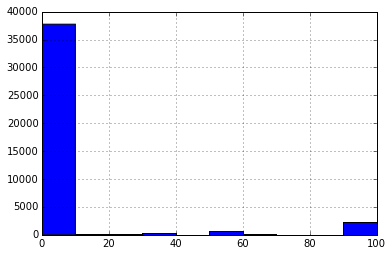

In [21]:
(with_softclip.n_overlap*100.0/with_softclip.total)[with_softclip.n_poses > 1].hist()

So in most cases where there is an overlap, the overlap is total. This probably means that there is only one UMI at the non-reference position.

What happens if we do this the other way around? Group reads by their mapping POS and then investigate the inferred position of these reads?

In [77]:
without_softclip = fraction_overlap("C18-02B-BIOQ-sktrim-um-star-ensembl-Aligned.sortedByCoord.out.1.bam", False)

In [78]:
print ("%.1f%%" % ((without_softclip.n_poses > 1).sum()*100.0/without_softclip.shape[0]))

5.6%


 So here 5.6% of positions have at least one read that has a different implied position to the rest of the reads. This is considerably higher than for grouping reads by their implied position. 

In [79]:
(without_softclip.n_overlap > 1)[without_softclip.n_poses > 1].value_counts()

False    63334
True       816
Name: n_overlap, dtype: int64

In [84]:
(without_softclip.n_overlap > 1)[without_softclip.n_poses > 1].value_counts()/float((without_softclip.n_poses >1).sum())

False    0.98728
True     0.01272
Name: n_overlap, dtype: float64

So the *fraction* of sites that have an overlap is more or less the same, but because there are more sites, then this is a higher absolute number of sites.

 

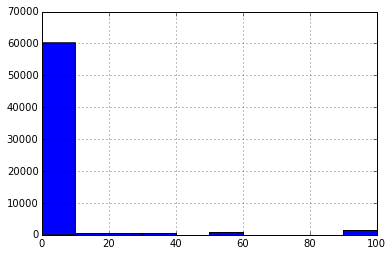

In [32]:
(without_softclip.n_overlap*100.0/without_softclip.total)[without_softclip.n_poses > 1].hist()

Now we wouldn't neccesarily expect all of the UMIs: in the situation where each UMI had only one read then in fact we would expect all the positions to have different UMIs. Also the above assumes that picking one reference position is the right way to go. This might not be the case. The below instead records could many of the locations in a group have at least one UMI that overlaps with at least one UMI in another position in the group. 

Of course they *could* be in the same UMI clusters, but we are assuming that errors that cause new UMIs are independent of errors that give reads new locations. Of course, this might not be true.

In [125]:
def any_overlap(bamfile, use_softclip, chrom=None):
    
    options = AttrDict({'get_umi_method': 'read_id',
           'per_cell': False,
           'per_gene': False,
           'detection_method': "NH",
           'whole_contig': False,
           'paired': False,
           'subset': None,
           'mapping_quality': None,
           'soft_clip_threshold': 4,
           'spliced': False,
           'use_softclip': use_softclip,
           'umi_sep' : '_',
           'read_length': False,
           'ignore_umi': False})
    
    bamfile = pysam.AlignmentFile(bamfile)
    reads = bamfile.fetch(reference=chrom)
    bundle_getter = get_bundles(options, all_reads=True)
    chrs, poses, n_overlap, totals, n_poses = [],[],[], [], []
    for bundle, _, _ in bundle_getter(reads):
        pos_dict = defaultdict(set)
    
        for umi in bundle:
            for read in bundle[umi]["read"]:
                pos_dict[get_read_position(read, 4, not use_softclip)[1]].add(umi)
        overlapping = 0
        np = 0
        while len(pos_dict) > 1:
            cur_pos = pos_dict.pop(pos_dict.keys()[0])
            if any(len(cur_pos.intersection(p)) > 0
                   for p in pos_dict.values()):
                overlapping += 1
            np += 1
        
        chrs.append(bundle_getter.current_chr)
        n_overlap.append(overlapping)
        n_poses.append(np)
        
    return pd.DataFrame({"Chr":chrs, "n_overlap": n_overlap,
                         "n_poses": n_poses})      

In [106]:
with_softclip = any_overlap("C18-02B-BIOQ-sktrim-um-star-ensembl-Aligned.sortedByCoord.out.1.bam", True)

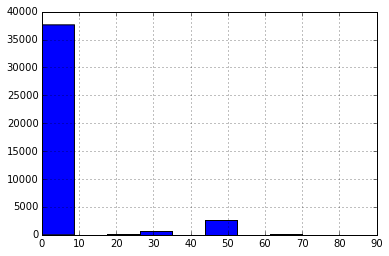

In [117]:
(with_softclip.n_overlap*100.0/(with_softclip.n_poses + 1))[with_softclip.n_poses > 0].hist()

In [112]:
"%.1f%%" % ((with_softclip.n_overlap > 0).sum()*100.0/(with_softclip.n_poses > 0).sum())

'8.9%'

There is a much larger group of positions where at least one UMI overlaps with an UMI from a different position in the group. Remeber, this is where the grouping is done by implied position and then we give reads in each group a position using the start of the alignment. There are about 41,000 groups where the reads have more than one reference position, and in 9% of cases the reads at some of these positions share UMIs. 

In [113]:
without_softclip = any_overlap("C18-02B-BIOQ-sktrim-um-star-ensembl-Aligned.sortedByCoord.out.1.bam", False) 

In [114]:
(without_softclip.n_overlap > 0).sum()*100.0/(without_softclip.n_poses > 0).sum()

7.1145752143413876

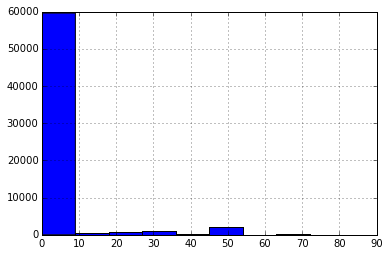

In [116]:
(without_softclip.n_overlap*100.0/(without_softclip.n_poses + 1))[without_softclip.n_poses > 0].hist()

So when we do the grouping the other way around, we get a (significantly?) smaller proportion of the groupings with overlapping UMIs, but from a much larger pool of positions. Does this mean that there are MORE positisions that share a UMI with another, overall?

In [120]:
(with_softclip.n_overlap > 0)[with_softclip.n_poses > 0].value_counts()

False    37626
True      3665
Name: n_overlap, dtype: int64

In [121]:
(without_softclip.n_overlap > 0)[without_softclip.n_poses > 0].value_counts()

False    59586
True      4564
Name: n_overlap, dtype: int64

When grouped by alignment start position a higher NUMBER of additional positions that are created by regrouping by implied position share an UMI, but this is a smaller fraction of all the positions. 

In [123]:
without_softclip.n_overlap.sum()*100.0/without_softclip.n_poses.sum()

7.1909109631358552

In [124]:
with_softclip.n_overlap.sum()*100.0/with_softclip.n_poses.sum()

8.6811571951834718

In [66]:
(without_softclip.n_poses > 0).sum()

64150

In [68]:
(with_softclip.n_poses > 0).sum()

41291

### With iCLIP sample

We need to repeat this analysis with several samples to ensure that the results are not sample specific. We will repeat the above with an iCLIP sample that is much more highly duplicated. 

In [126]:
 iclip_softclip = any_overlap("merged_Alyref-FLAG-R2.star.bam", True, "chr1")

In [131]:
"%.1f%%" %((iclip_softclip.n_poses > 0).sum()*100.0/iclip_softclip.shape[0])

'10.3%'

In [128]:
"%.1f%%" % ((iclip_softclip.n_overlap > 0).sum()*100.0/(iclip_softclip.n_poses > 0).sum())

'95.3%'

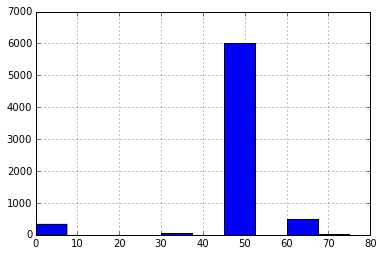

In [129]:
(iclip_softclip.n_overlap*100.0/(iclip_softclip.n_poses + 1))[iclip_softclip.n_poses > 0].hist()

In [132]:
 iclip_nosoftclip = any_overlap("merged_Alyref-FLAG-R2.star.bam", False, "chr1")

In [133]:
"%.1f%%" %((iclip_nosoftclip.n_poses > 0).sum()*100.0/iclip_nosoftclip.shape[0])

'1.6%'

In [134]:
"%.1f%%" % ((iclip_nosoftclip.n_overlap > 0).sum()*100.0/(iclip_nosoftclip.n_poses > 0).sum())

'32.4%'

So now the two position methods are very different! 10% of positions grouped by implied start position give more than one position when grouped by aligned start position, and in 95% of those cases there is an overlap between the UMIs at the different positions. 

Meanwhile only 1.5% of positions grouped by alignment start give more than one position when grouped by implied start and in only 30% of these cases do the positions share UMIs.

While even the numbers in the second analysis are higher than either of the analysis for the first sample, the numbers are WAY lower than in the first analysis here. This suggests to me that for this sample the first method (group by implied start position) is the correct one.
